In [ ]:
!pip install torch
!pip install torchvision
!pip install matplotlib

In [11]:
# Import necessary libraries
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
from PIL import Image
torch.manual_seed(0)

In [12]:
# Set image size
IMAGE_SIZE = 28  # Using 28 instead of 16 for better accuracy

# Create a function to display images
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

# Define transforms
composed = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

In [13]:
# Create training and validation datasets
dataset_train = dsets.FashionMNIST(root='./fashion/data', train=True, transform=composed, download=True)
dataset_val = dsets.FashionMNIST(root='./fashion/data', train=False, transform=composed, download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 22.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 349kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.24MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.8MB/s]


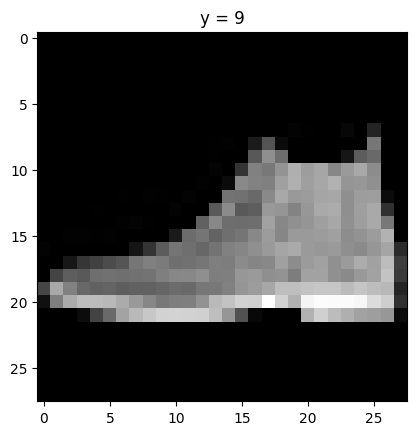

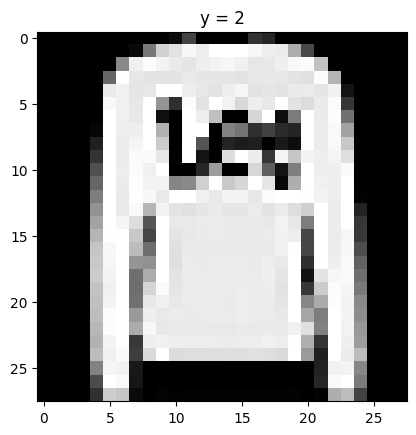

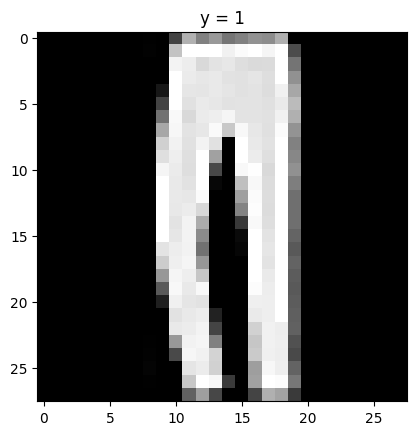

<Figure size 640x480 with 0 Axes>

In [14]:
# Display the first three images from validation dataset
for n, data_sample in enumerate(dataset_val):
    show_data(data_sample)
    plt.figure()
    if n == 2:
        break

In [15]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100)
test_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=100)

In [16]:
class CNN_batch(nn.Module):
    
    # Constructor
    def __init__(self, out_1=32, out_2=64, number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Additional convolutional layer for better feature extraction
        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_2*2, kernel_size=3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(out_2*2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        # Calculate the size of the flattened feature map
        flattened_size = out_2 * 2 * (IMAGE_SIZE // 8) * (IMAGE_SIZE // 8)
        
        self.fc1 = nn.Linear(flattened_size, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        
        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [17]:
# Create model instance
model = CNN_batch()

In [18]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [19]:
# Train the model
import time
start_time = time.time()

cost_list = []
accuracy_list = []
N_test = len(dataset_val)
n_epochs = 10  # Increase epochs for better accuracy

In [20]:
for epoch in range(n_epochs):
    cost = 0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost += loss.item()
    
    correct = 0
    # Perform a prediction on the validation data
    model.eval()
    for x_test, y_test in test_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)
    print(f"Epoch: {epoch+1}, Cost: {cost:.4f}, Accuracy: {accuracy:.4f}")

Epoch: 1, Cost: 237.0564, Accuracy: 0.8706
Epoch: 2, Cost: 153.3325, Accuracy: 0.9019
Epoch: 3, Cost: 128.4572, Accuracy: 0.9032
Epoch: 4, Cost: 109.8548, Accuracy: 0.9073
Epoch: 5, Cost: 97.3433, Accuracy: 0.9093
Epoch: 6, Cost: 83.4282, Accuracy: 0.9118
Epoch: 7, Cost: 73.7107, Accuracy: 0.9144
Epoch: 8, Cost: 63.0187, Accuracy: 0.9123
Epoch: 9, Cost: 57.5894, Accuracy: 0.9068
Epoch: 10, Cost: 50.6609, Accuracy: 0.8941


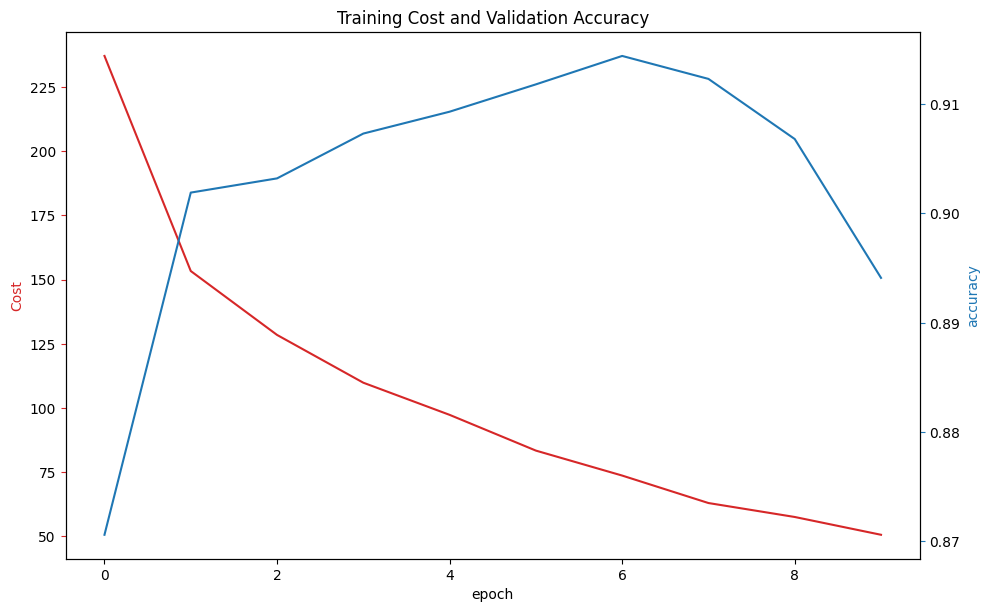

In [22]:
# Plot Cost and Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color='black')
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
plt.title("Training Cost and Validation Accuracy")
plt.show()